In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from dateutil import parser
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from pyxlsb import open_workbook as open_xlsb
df = []

with open_xlsb('database/19-01-04_Séjours_2018.xlsb') as wb:
    with wb.get_sheet(1) as sheet:
        for row in sheet.rows():
            df.append([item.v for item in row])

df = pd.DataFrame(df[1:], columns=df[0])


In [ ]:
# df.to_csv

# Time Analysis

In [3]:
df_2018 = df.copy()

In [4]:
df_2019 = pd.read_excel('database/20-01-02_Séjours_2019.xlsx')

In [5]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_occ = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

### Time Analysis Functions

In [6]:
def serial_date_to_string(srl_no):
    new_date = datetime.datetime(1900,1,1,0,0) + datetime.timedelta(srl_no - 1)
    date_parsed = parser.parse(new_date.strftime("%Y-%m-%d"))
    return date_parsed

    
def epoch_day_to_time(srl_no):
    new_date = datetime.datetime(1900,1,1,0,0) + datetime.timedelta(srl_no - 1)
    return new_date.strftime("%Y-%m-%d")

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def camp_occ_calculator(df, camp, plot=True):
    """
    gets df and camp name to calculate daily occ per specific date convertor.
    
    """
    df_camp = df[df['camping_label'] == camp]
    
    if np.dtype(df_camp['datein']) == float:
        df_camp['new_date_in'] = df_camp['datein'].apply(lambda x: serial_date_to_string(x))
        df_camp['new_date_out'] = df_camp['dateout'].apply(lambda x: serial_date_to_string(x))
    else:
        df_camp['new_date_in'] = df_camp['datein']
        df_camp['new_date_out'] = df_camp['dateout']

    season = pd.date_range(start=min(df_camp['new_date_in']),end=max(df_camp['new_date_out']))
    dict_dates = defaultdict(int)
    for date in season:
        dict_dates[date] = 0

    for index in df_camp.index:
        for j in range(int(df_camp['los'][index])):
            dict_dates[pd.Timestamp(df_camp['new_date_in'][index]) + pd.DateOffset(days=j)] += 1
    df_date = pd.DataFrame(index=dict_dates.keys(), data=dict_dates.values())
    df_date = df_date[df_date[0] != 0]
    
    if plot:
        plot_occ(df_date, camp)
        plot_daliy_occ(df_date)
        plot_daliy_occ(df_date, time='day')
        
    return df_date

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def plot_occ(df, camp):
    """
    plot summarize occ data per interval
    """
    interval = ['M', 'd']
    year = list(map(str, (df.index.year.min(), df.index.year.max())))
    for i, t in enumerate(interval, 1):
        plt.subplot(1,2,i)
        df[0].resample(t).mean().plot(figsize=(15,5))
        plt.title(camp, fontsize=20)
        plt.ylabel('Occ')
        

def plot_daliy_occ(df, time=None):
    """
    Gets Avg Occ per month for date indexed df
    params: df of specific camp for specific year
            time, if None plot by day of the month else by week
    return: daily avg occ plot
    """
    if time != None:
        time = df.index.dayofweek
        x_label = "Days of Week" 
    else:
        time = df.index.day
        x_label = "Days of Month" 
        
    df.groupby([time, df.index.month]).mean().unstack().plot(figsize=(10,5), label='Inline label')
    plt.title('Daily Occ')
    plt.ylabel('OCC')
    plt.xlabel(x_label)
    plt.legend(months, loc='best', bbox_to_anchor=(1,1))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def run_predictor(train, test, model, test_year=2019):
    """
    Combine train and test df i.e. past and the test future df, using specified model.
    shift data by 10 days to prepare new data frame for autoregressor models.
    params: train, past years of camp occupations data
            test, future year to test model on 
    returns: prediction score and sanity checks for splited data.
    """
    df = train.append(test)
    print(f'Dates range:\n{df.index.min()} - {df.index.max()}\n')
    shifted_data = pd.DataFrame({f't{k}': df[0].shift(k) for k in range(30)})
    shifted_data = shifted_data[~shifted_data.isna().any(axis=1)]
    X = shifted_data.drop(columns='t0')
    y = shifted_data.t0
    print(*list(zip(('X shape: ', 'y shape: '), (X.shape, y.shape))), sep='\n')

    # Split Train Test
    X_train = X[X.index.year != test_year]
    X_test = X[y.index.year == test_year]
    y_train = y[X.index.year != test_year]
    y_test = y[y.index.year == test_year]
    print(*list(zip(('X_train shape: ', 'X_test shape: ', 'y_train shape: ', 'y_test shape: '),(X_train.shape, X_test.shape, y_train.shape, y_test.shape))), sep='\n')
    
    # Run predictor
    if model == ARIMA:
        reg = model(X_train, order=(1,1,1))
        reg.fit()
    else:
        reg = model()
        
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f'R2:\t{round(r2_score(y_test, y_pred),3)}\nRMSE:\t{round(mean_squared_error(y_test, y_pred),2)}')
    
        
    f, a = plt.subplots(1,1,figsize = (10,5), sharex=True)
    plt.plot(y_test.index.month, y_test, label='Observed')
    plt.plot(y_test.index.month, y_pred, label='Forecast')
    plt.ylabel('Occ.')
    plt.xlabel('Date')
    plt.title('Prediction vs Past model Evaluation')
    plt.legend()
    
    
#     return X_train, X_test, y_train, y_test

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



## Analysis Per Camp

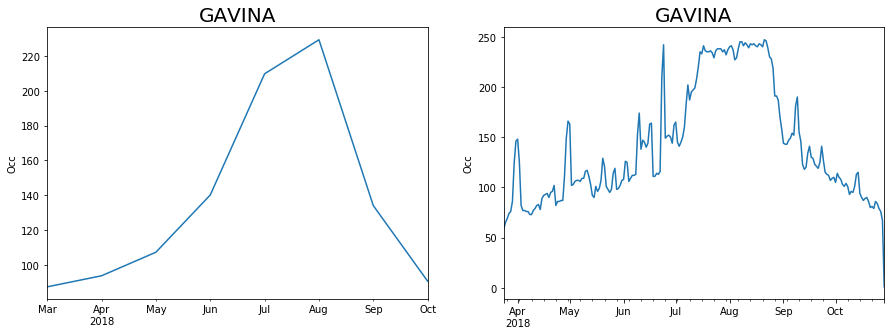

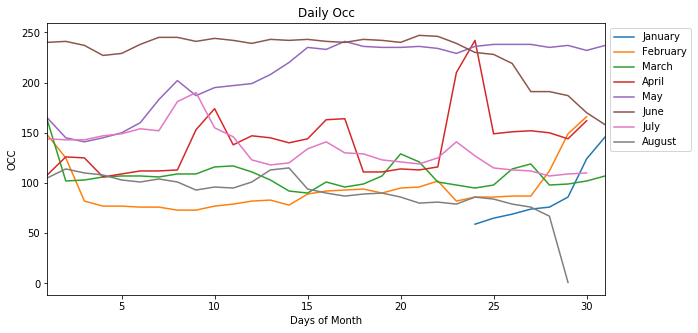

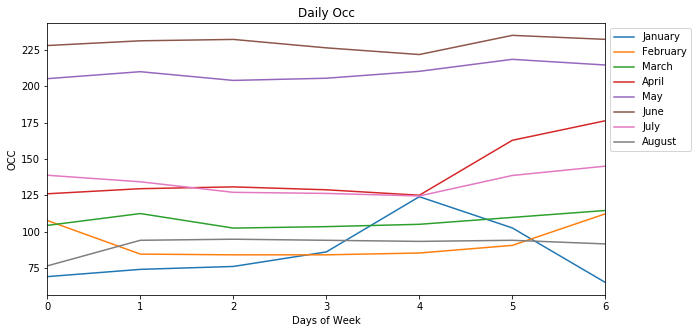

In [15]:
df_gavina_2018 = camp_occ_calculator(df_2018, "GAVINA")
# df_gavina_2019 = camp_occ_calculator(df_2019, "GAVINA")

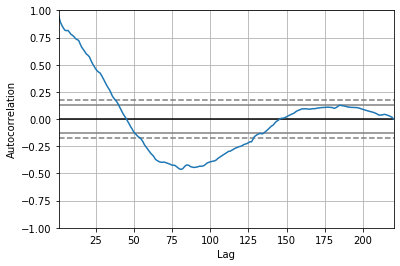

In [8]:
pd.plotting.autocorrelation_plot(df_gavina_2018)

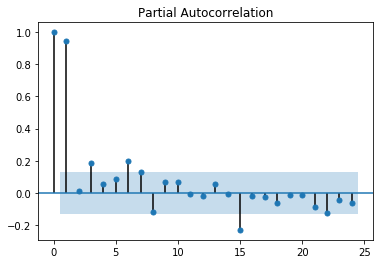

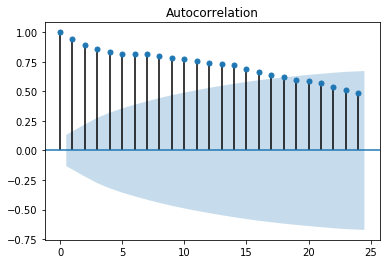

In [9]:
plot_pacf(df_gavina_2018);
plot_acf(df_gavina_2018);

<Figure size 1080x360 with 0 Axes>

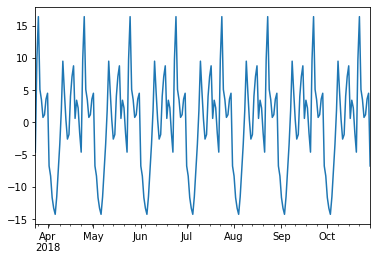

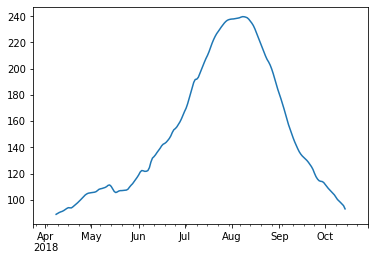

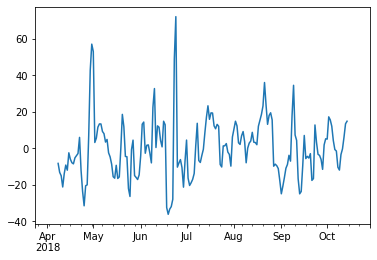

In [10]:
plt.figure(figsize=(15,5));
sd(df_gavina_2018, model='additive', freq=30).seasonal.plot(legend=False);
sd(df_gavina_2018, model='additive', freq=30).trend.plot(legend=False);
sd(df_gavina_2018, model='additive', freq=30).resid.plot(legend=False);

# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=20);

Dates range:
2018-03-24 00:00:00 - 2019-11-02 00:00:00

('X shape: ', (403, 29))
('y shape: ', (403,))
('X_train shape: ', (191, 29))
('X_test shape: ', (212, 29))
('y_train shape: ', (191,))
('y_test shape: ', (212,))
R2:	0.866
RMSE:	482.18


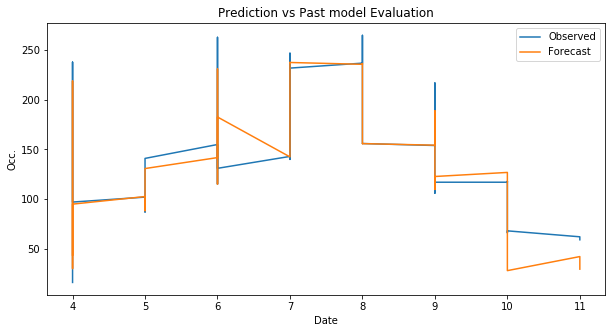

In [12]:
predict = run_predictor(df_gavina_2018, df_gavina_2019, RandomForestRegressor)

# All Camps



Train TS Analysis On 2018 TURISCAMPO Occ.




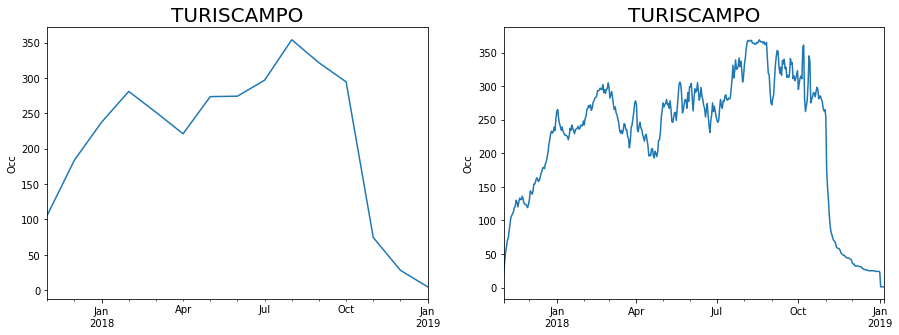

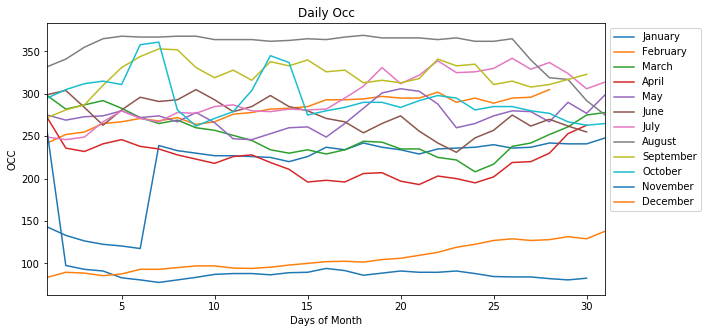

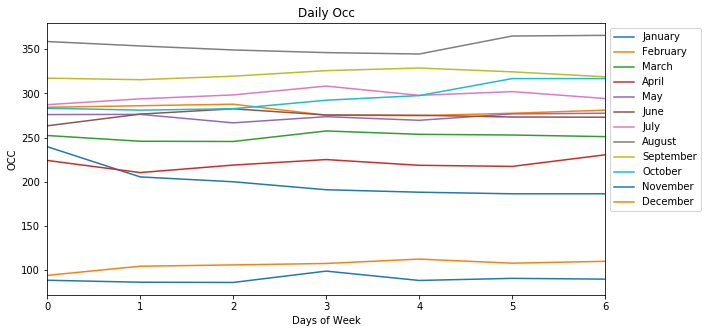



Test TS Analysis On 2019 TURISCAMPO Occ.




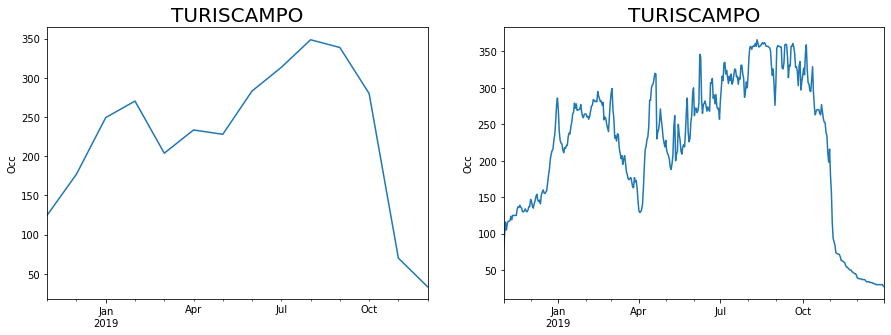

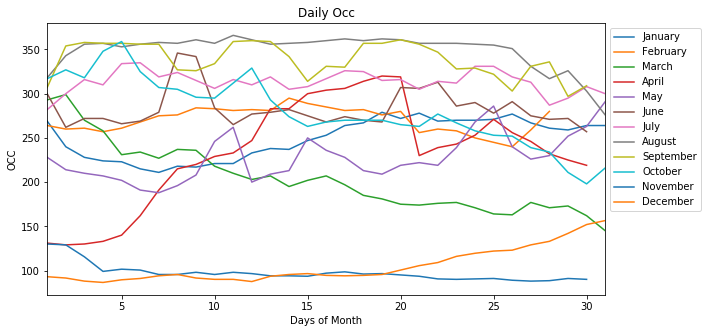

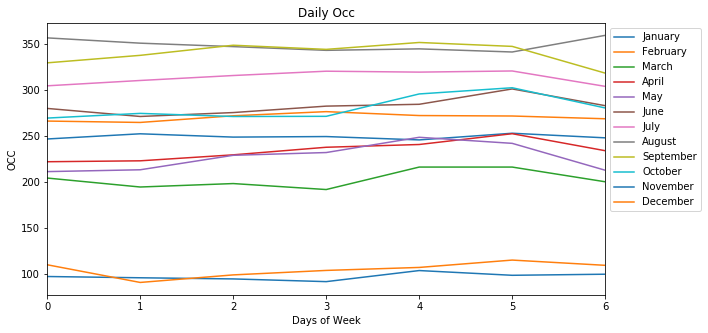



Error name 'run_predicator' is not defined for TURISCAMPO




Train TS Analysis On 2018 PETITS CAMARGUAIS Occ.




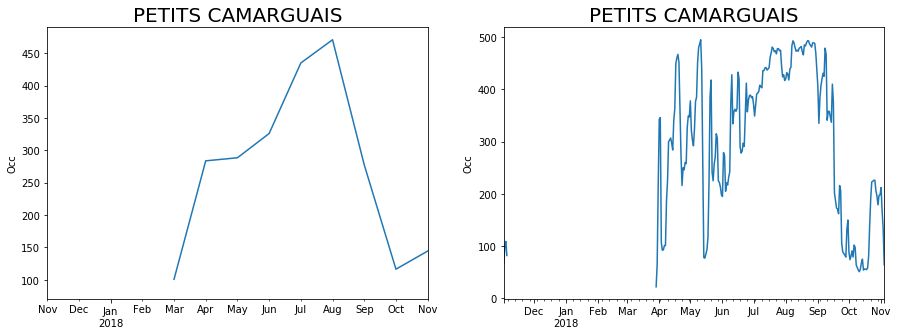

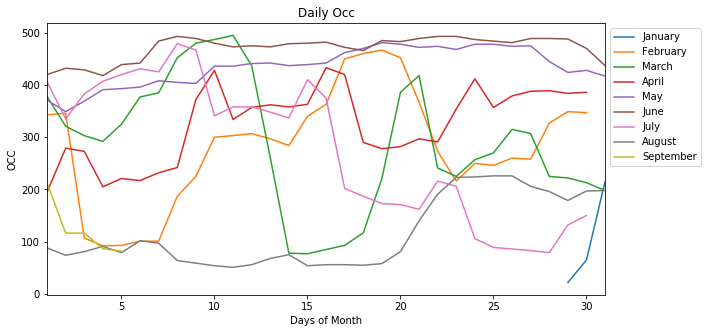

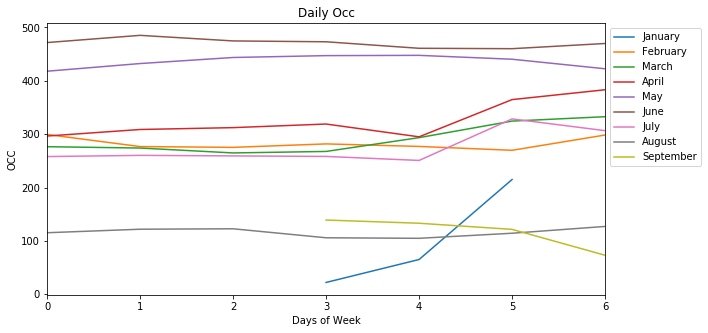



Test TS Analysis On 2019 PETITS CAMARGUAIS Occ.




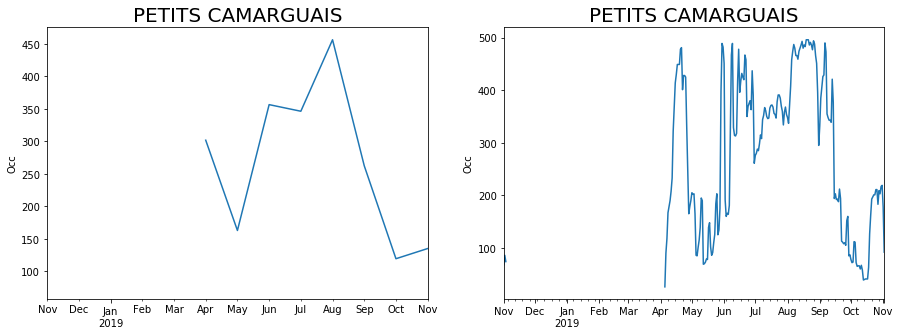

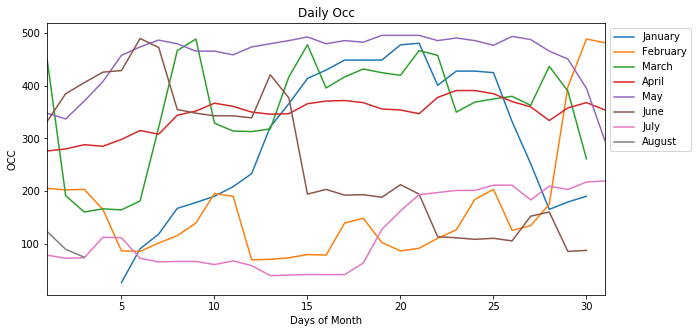

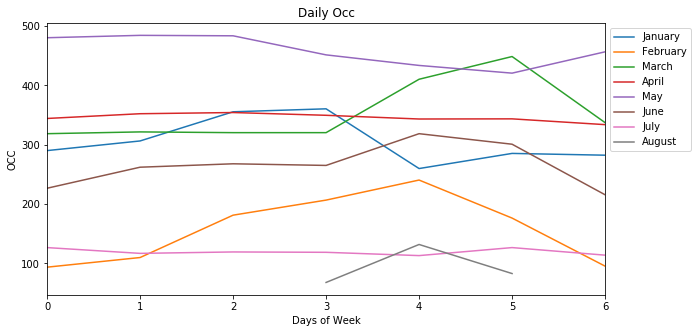



Error name 'run_predicator' is not defined for PETITS CAMARGUAIS




Train TS Analysis On 2018 TOURNELS Occ.




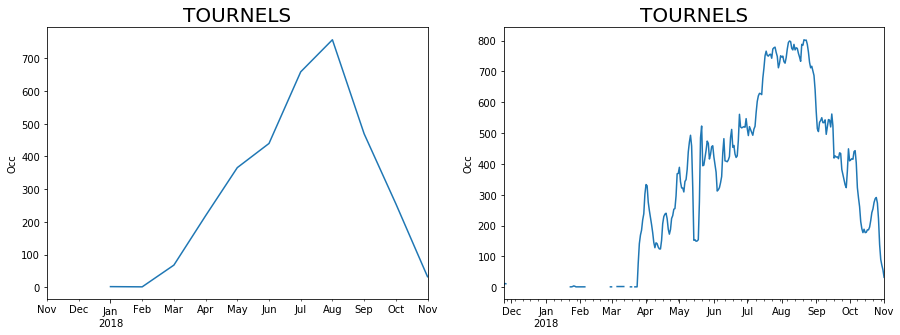

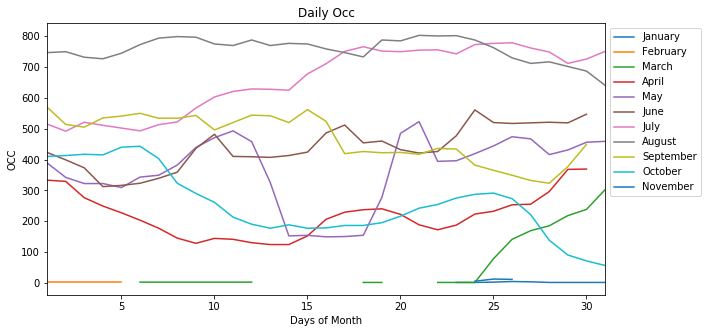

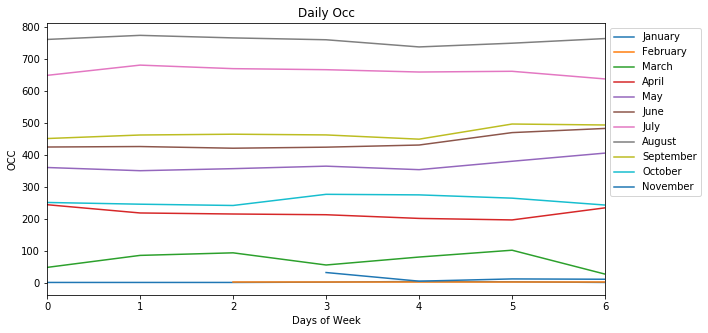



Test TS Analysis On 2019 TOURNELS Occ.




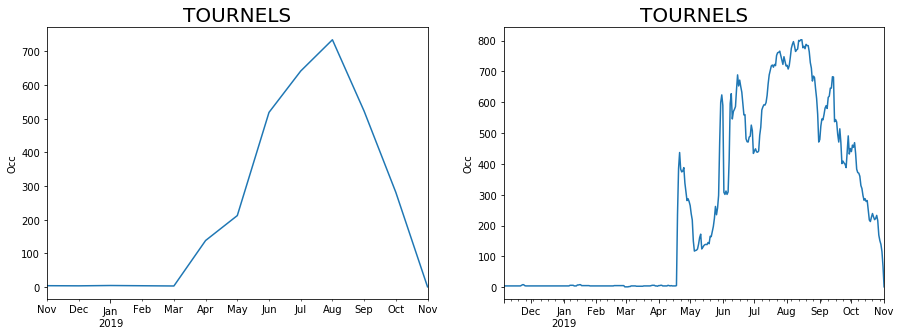

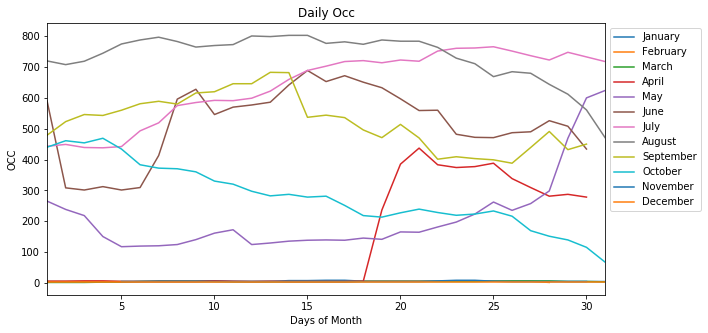

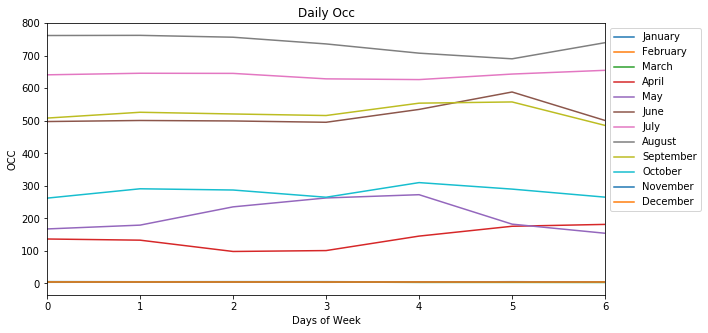



Error name 'run_predicator' is not defined for TOURNELS


['TURISCAMPO', 'PETITS CAMARGUAIS', 'TOURNELS']


In [14]:
camps = df['camping_label'].unique().tolist()[:3]
error = []
for camp in camps:
    try:
        print(f"\n\nTrain TS Analysis On 2018 {camp} Occ.\n\n")
        train = camp_occ_calculator(df_2018, camp)
        plt.show()
        print(f"\n\nTest TS Analysis On 2019 {camp} Occ.\n\n")
        test = camp_occ_calculator(df_2019, camp)
        plt.show()
        predict = run_predicator(train, test, RandomForestRegressor)
    except Exception as e:
        print(f"\n\nError {e} for {camp}\n\n")
        error.append(camp)
print(error)